In [3]:
## Import AIDC libraries
!pip install /project_data/data_asset/aidc-1.3.zip --force-reinstall;
import aidc

Processing /project_data/data_asset/aidc-1.3.zip
  Preparing metadata (setup.py) ... done
  Using cached javascript-1%211.0.3-py3-none-any.whl (33 kB)
  Created wheel for aidc: filename=aidc-1.3-py3-none-any.whl size=138109 sha256=4844da091a5213436be5d54bb87ccf4fe549a5b0b8361f627715b7a23a8b7f21
  Stored in directory: /tmp/1000710000/.cache/pip/wheels/36/35/e2/ffafef2711229494b6f5514e8d265d330c9b11bfa3285f4fce
Successfully built aidc
  Attempting uninstall: javascript
    Found existing installation: javascript 1!1.0.3
    Uninstalling javascript-1!1.0.3:
      Successfully uninstalled javascript-1!1.0.3
  Attempting uninstall: aidc
    Found existing installation: aidc 1.3
    Uninstalling aidc-1.3:
      Successfully uninstalled aidc-1.3


In [11]:
## Load the AIDC model from csv
import pandas as pd
import matplotlib.pyplot as plt
import io
df = pd.read_csv("/project_data/data_asset/credit_human_ml.csv", sep=",",nrows=5500)

tbcs=aidc.create_table_case_source({ 'name': "initial" })
table = aidc.load_pandas_data(df)
taskmodel_data={
  'id': "0",
  'name': "taskModel2",
  'description': "test2"
    }
taskmodel=aidc.create_task_model(taskmodel_data)
result = tbcs.build(table)
taskmodel.initFromBuiltCaseSource(tbcs, result)

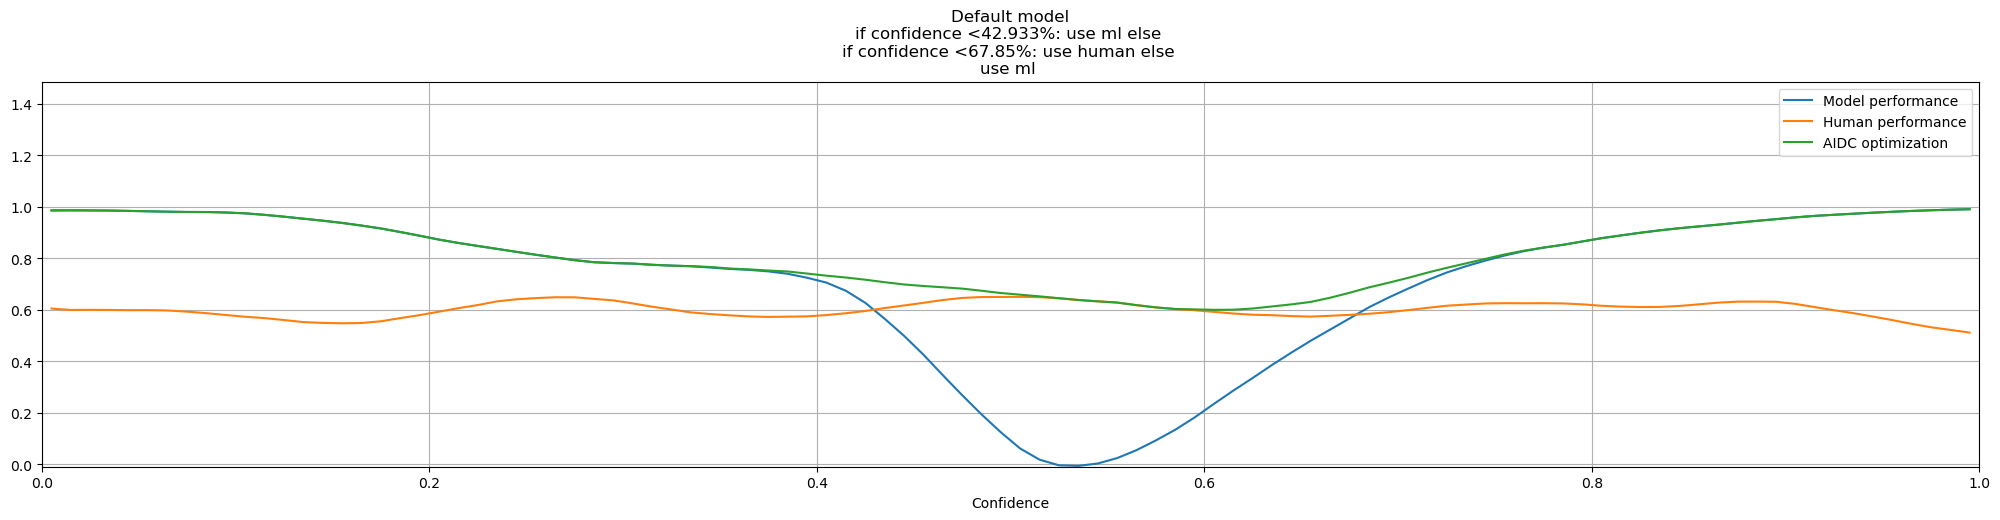

In [12]:
#Show default statistics
global_statistics = aidc.output_global_stats(taskmodel)
output_curves_data = aidc.output_curves(taskmodel)
performance = aidc.get_analyses(taskmodel)

scenario=taskmodel.getScenario()

params = {
    "indicator": "Performance",
    "attribute": taskmodel.defaultConfidenceProvider  
}

stats=scenario.overviewStats(taskmodel,params)
curves=scenario.exportOverviewStats(taskmodel,True,stats)

dispatch_description=aidc.dispatch_description(taskmodel)
        
global_statistics = aidc.output_global_stats(taskmodel)
performance = aidc.get_analyses(taskmodel)
    
df = pd.read_csv(io.StringIO(curves),sep='\t')
min_values=df.min()
max_values=df.max()
margin_factor=1.5
min_limit=min(min_values[df.columns[df.columns.str.contains('performance')]])*margin_factor
max_limit=max(max_values[df.columns[df.columns.str.contains('performance')]])*margin_factor
df.plot(title="Default model" +"\n" + dispatch_description ,xlabel="Confidence",x="Unnamed: 0",y=["ml weighted average performance","human weighted average performance","initial scenario weighted average performance"],ylim=[min_limit,max_limit],xlim=[0,1],figsize=(25, 5),grid=True)
plt.legend(["Model performance", "Human performance", "AIDC optimization"])
plt.show() 

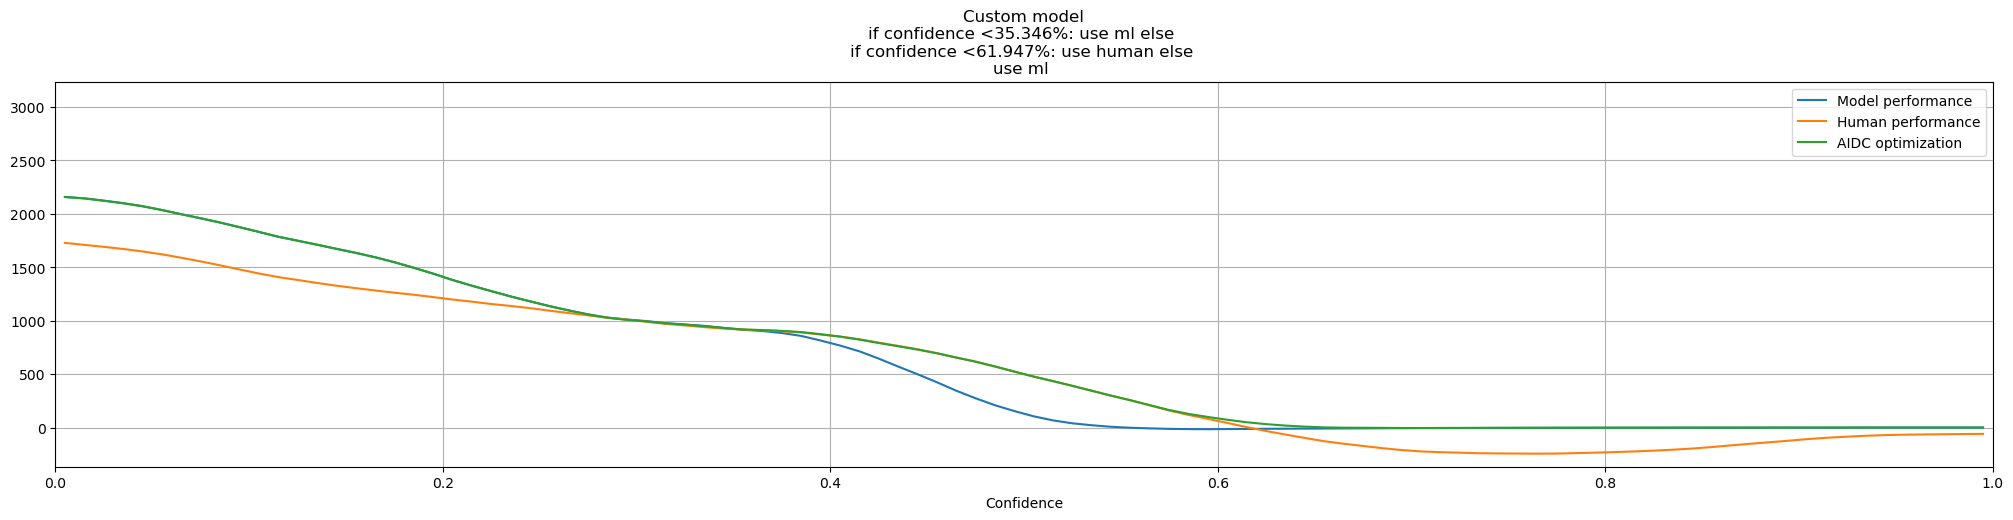

In [13]:
#Configure cost model
######################## Edit the values for your custom cost model. ############################
TruePositiveCost = "0"
FalsePositiveCost = "-LoanAmount*0.01"
FalseNegativeCost = "-LoanAmount*0.5"
TrueNegativeCost = "LoanAmount*0.3"
ModelDecisionCost = "-0.02"
HumanDecisionCost = "-0.05"
#################################################################################################

aidc.set_custom_indicators(taskmodel, TruePositiveCost, FalsePositiveCost, FalseNegativeCost, TrueNegativeCost, ModelDecisionCost, HumanDecisionCost)
scenario=taskmodel.getScenario()

params = {
    "indicator": "Performance",
    "attribute": taskmodel.defaultConfidenceProvider  
}

stats=scenario.overviewStats(taskmodel,params)
curves=scenario.exportOverviewStats(taskmodel,True,stats)

dispatch_description=aidc.dispatch_description(taskmodel)
        
global_statistics = aidc.output_global_stats(taskmodel)
performance = aidc.get_analyses(taskmodel)
    
df = pd.read_csv(io.StringIO(curves),sep='\t')
min_values=df.min()
max_values=df.max()
margin_factor=1.5
min_limit=min(min_values[df.columns[df.columns.str.contains('performance')]])*margin_factor
max_limit=max(max_values[df.columns[df.columns.str.contains('performance')]])*margin_factor
df.plot(title="Custom model" +"\n" + dispatch_description ,xlabel="Confidence",x="Unnamed: 0",y=["ml weighted average performance","human weighted average performance","initial scenario weighted average performance"],ylim=[min_limit,max_limit],xlim=[0,1],figsize=(25, 5),grid=True)
plt.legend(["Model performance", "Human performance", "AIDC optimization"])
plt.show() 

In [19]:
## Export the most optimal model to JSON
import json
model_export=aidc.export_model(taskmodel)

## Save the most optimal AIDC rules
from project_lib import Project
from ibm_watson_studio_lib import access_project_or_space
import imageio as iio
wslib = access_project_or_space()
token = wslib.auth.get_current_token()
project = Project(project_id=wslib.here.get_ID(), project_access_token=token)
project.save_data(file_name = "AIDC_model.json",data = json.dumps(model_export.valueOf()).encode('utf-8'),overwrite=True)

{'file_name': 'AIDC_model.json',
 'message': 'File saved to project storage.',
 'asset_id': '68c4e480-fce8-405c-8446-8e59f688b471'}